In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tracker
import stats
import visualizer
import utils

import importlib

import os

In [4]:
# Get Data
data_folder = "./VISEM_Simple_Dataset/"

filenames = os.listdir(data_folder)

if ".DS_Store" in filenames:
    filenames.remove(".DS_Store")

#print(filenames)

# Separate videos from csv files
csvfiles = []
videofiles = []
for filename in filenames:
    if filename.endswith(".csv"):
        csvfiles.append(filename)
    elif filename.endswith(".mp4"):
        videofiles.append(filename)
    else:
        print("Unknown file type: ", filename)

csvfiles.sort()
videofiles.sort()

print(videofiles)
print(csvfiles)


['11.mp4', '12.mp4', '13.mp4', '14.mp4', '15.mp4', '19.mp4', '21.mp4', '22.mp4', '24.mp4', '29.mp4', '30.mp4', '35.mp4', '36.mp4', '38.mp4', '47.mp4', '52.mp4', '54.mp4', '60.mp4', '82.mp4']
['11_labels.csv', '12_labels.csv', '13_labels.csv', '14_labels.csv', '15_labels.csv', '19_labels.csv', '21_labels.csv', '22_labels.csv', '24_labels.csv', '29_labels.csv', '30_labels.csv', '35_labels.csv', '36_labels.csv', '38_labels.csv', '47_labels.csv', '52_labels.csv', '54_labels.csv', '60_labels.csv', '82_labels.csv']


In [5]:
# Visualize example
example_vid = data_folder + videofiles[0]
example_csv = data_folder + csvfiles[0]

df = utils.loadDataFrame(example_csv)

visualizer.runVisualization(example_vid, df, visualization="flow")

(57, 3)
Video Finished.


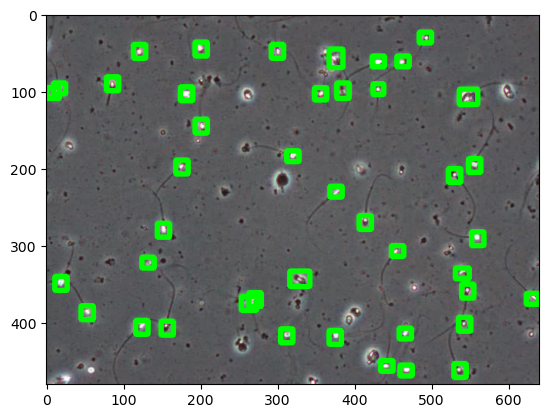

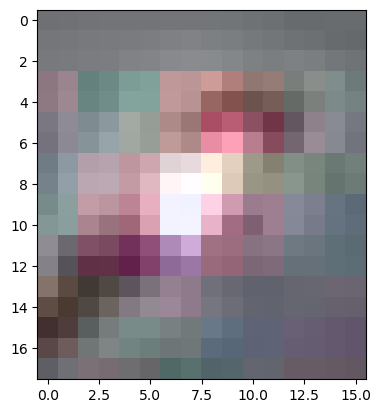

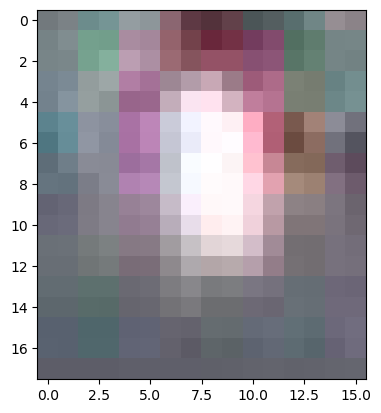

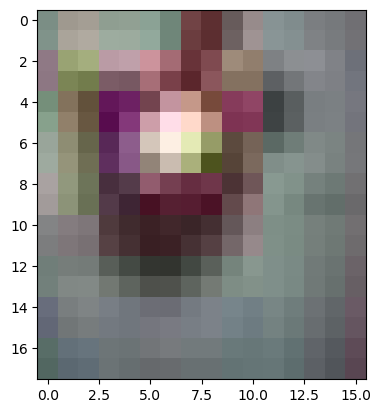

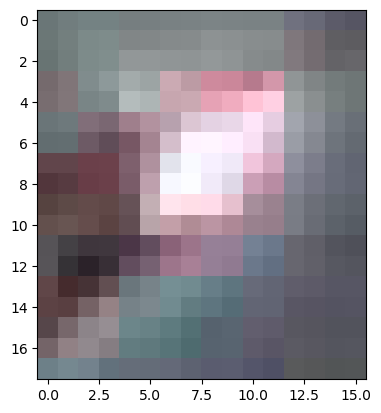

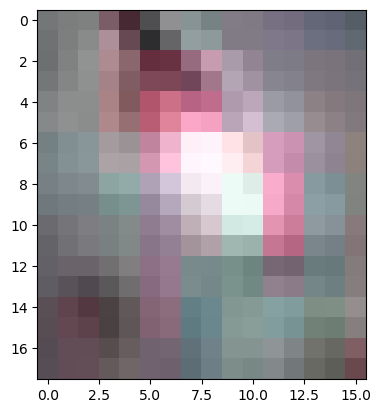

In [16]:
# Example bounding boxes
cap = cv2.VideoCapture(example_vid)

# Get the first frame
ret, frame = cap.read()

original = frame.copy()

res_h, res_w, _ = frame.shape

# Grab the bounding boxes in the first frame
sperm = df[df["frame"] == 0]

for i in range(len(sperm)):
    x = int(sperm.iloc[i]["x"])
    y = int(sperm.iloc[i]["y"])
    w = int(sperm.iloc[i]["bbox_w"])
    h = int(sperm.iloc[i]["bbox_h"])
    cv2.rectangle(frame, (x-w, y-h), (x + w, y + h), (0, 255, 0), 5)
plt.imshow(frame)
plt.show()

# Visualize bounding box regions
for i in range(5):
    x = int(sperm.iloc[i]["x"])
    y = int(sperm.iloc[i]["y"])
    w = int(sperm.iloc[i]["bbox_w"])
    h = int(sperm.iloc[i]["bbox_h"])
    im = original[y-h:y+h, x-w:x+w]
    plt.imshow(im)
    plt.show()  


(18, 16, 3)


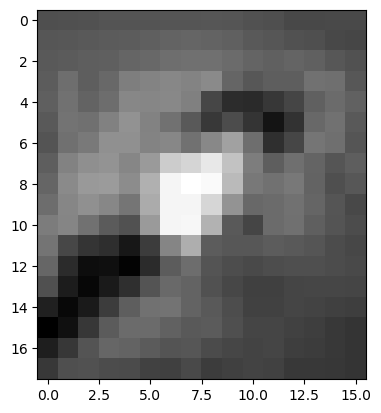

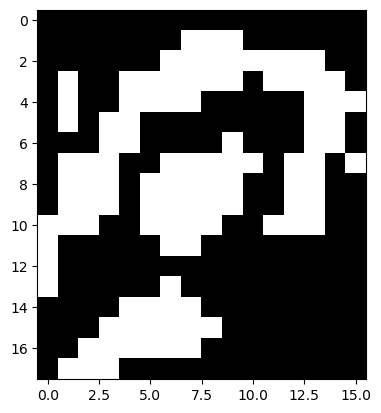

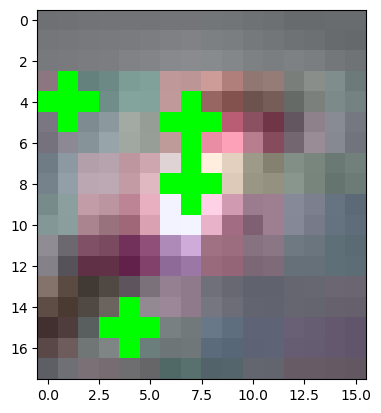

(18, 16, 3)


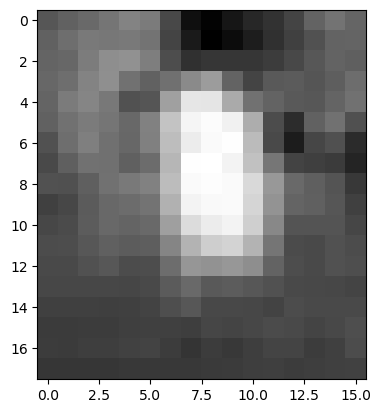

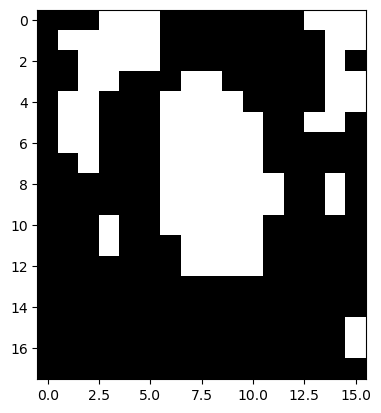

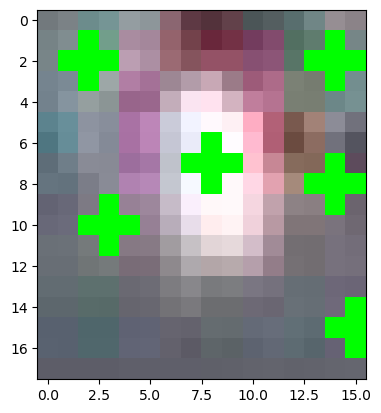

(18, 16, 3)


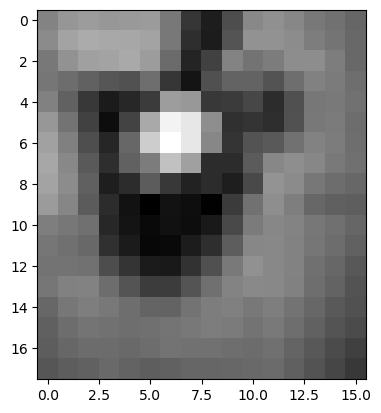

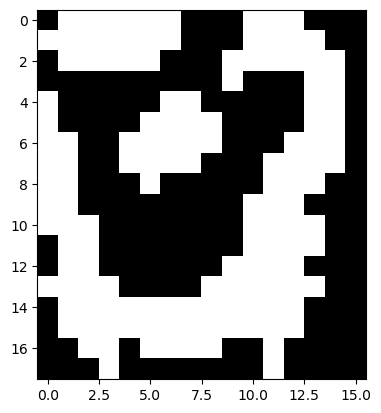

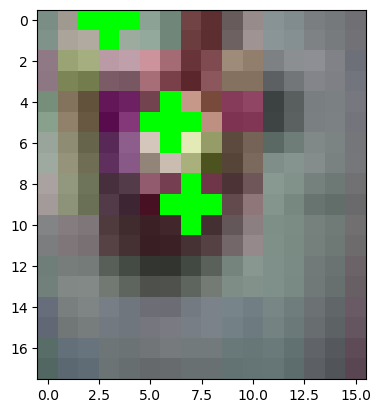

(18, 16, 3)


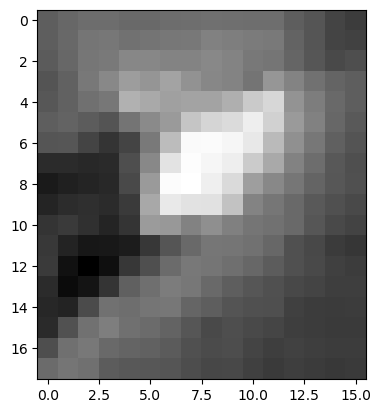

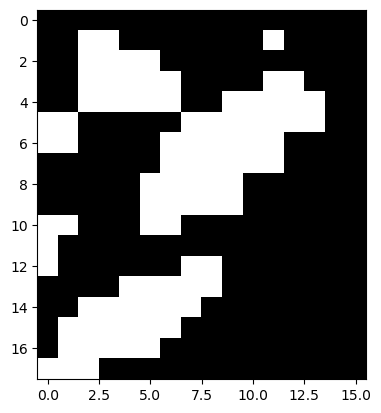

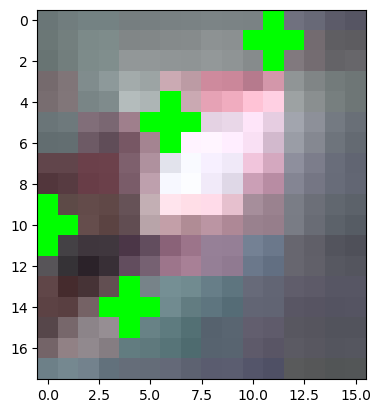

(18, 16, 3)


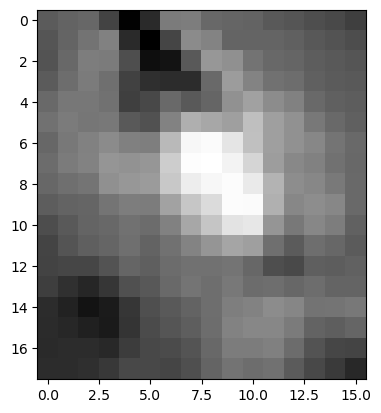

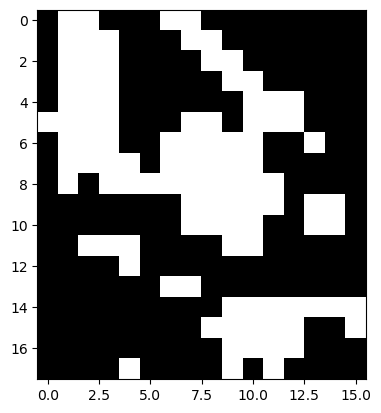

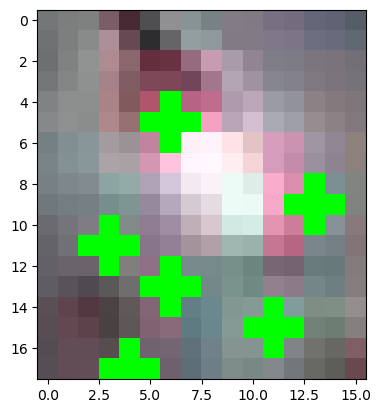

(18, 16, 3)


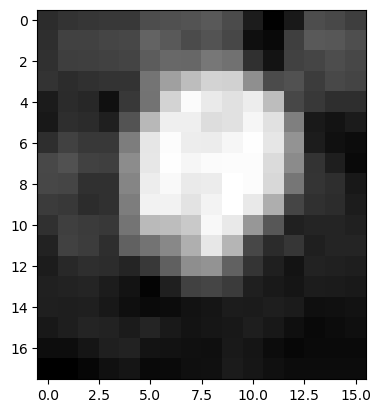

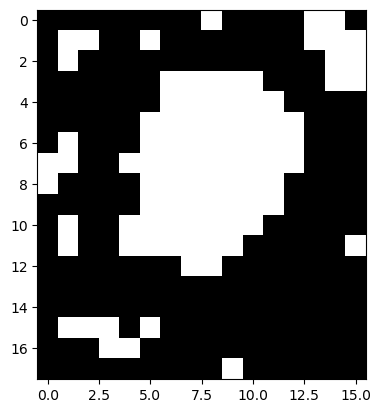

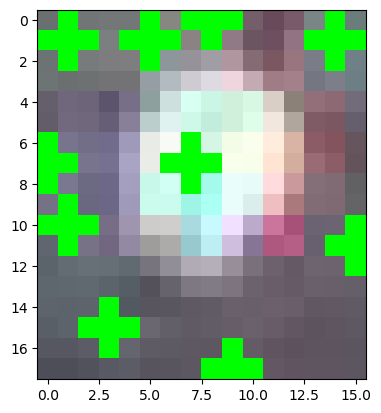

(18, 16, 3)


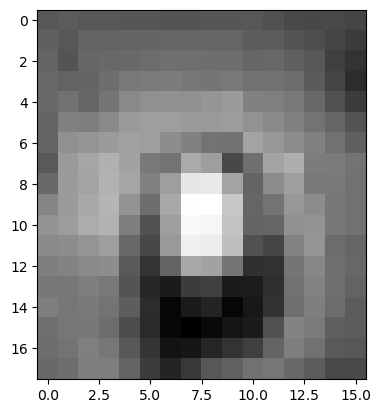

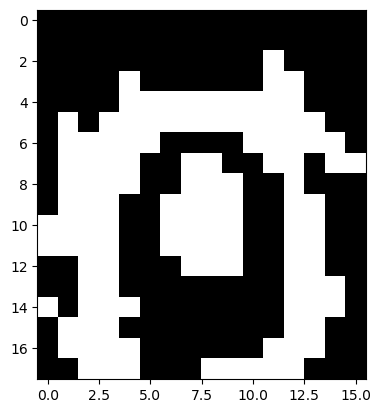

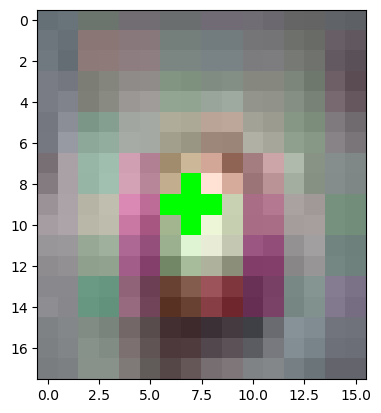

(18, 16, 3)


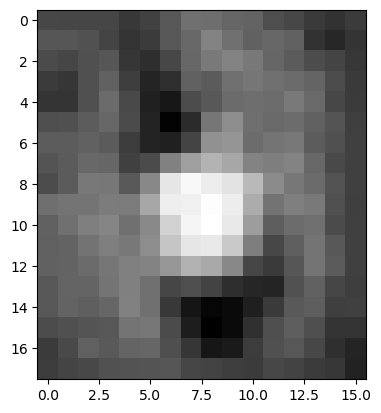

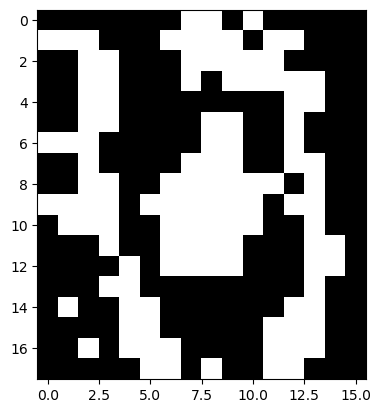

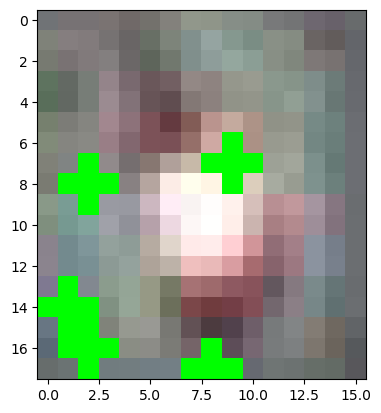

(18, 16, 3)


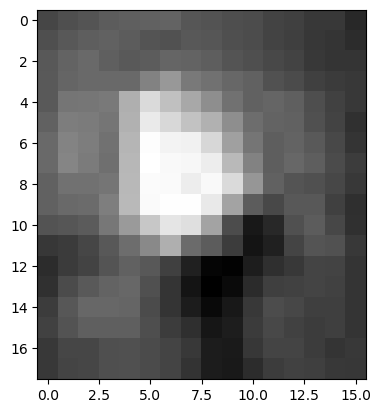

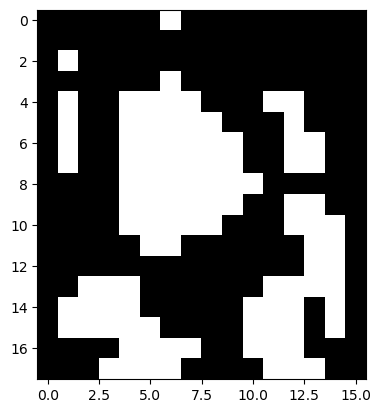

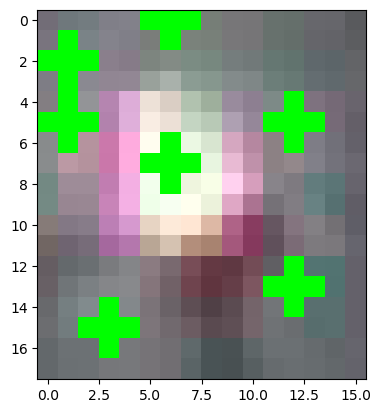

(18, 16, 3)


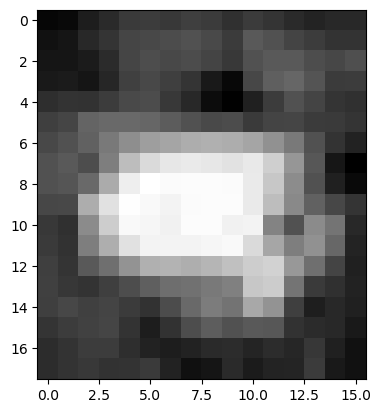

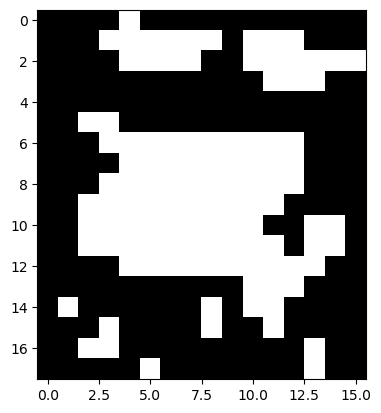

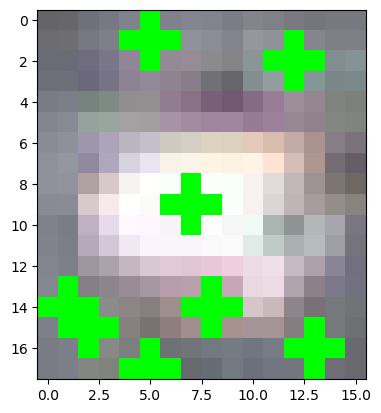

(18, 16, 3)


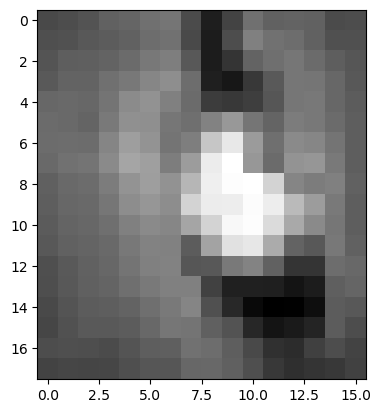

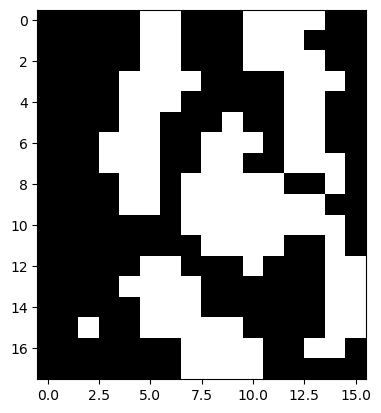

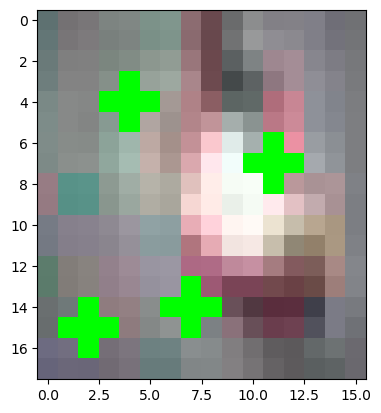

(18, 16, 3)


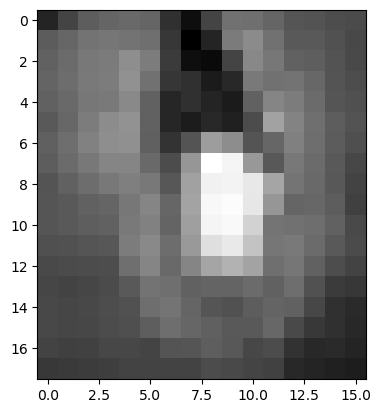

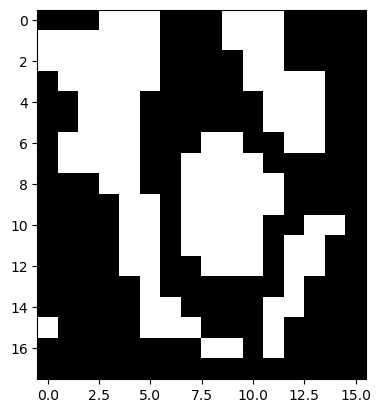

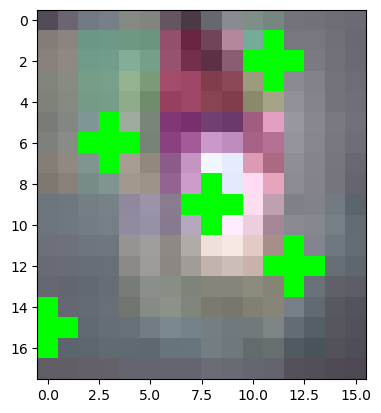

(18, 16, 3)


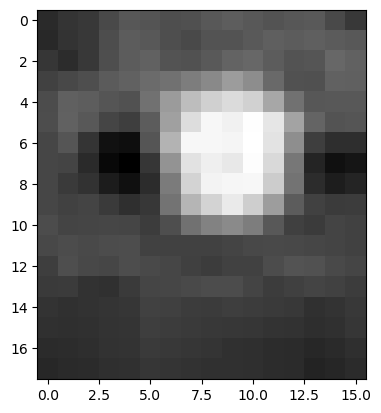

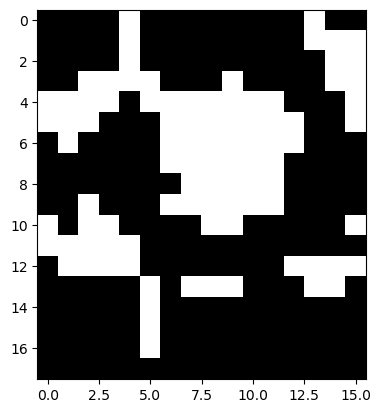

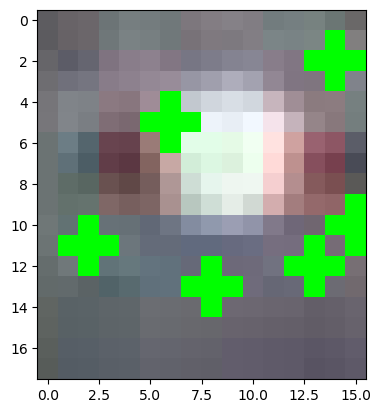

(18, 16, 3)


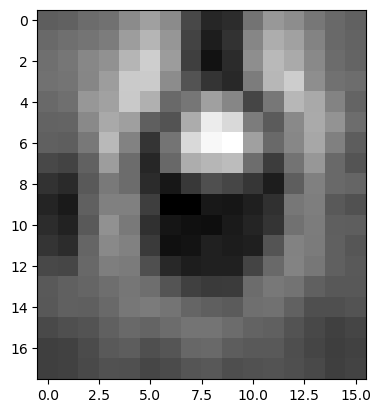

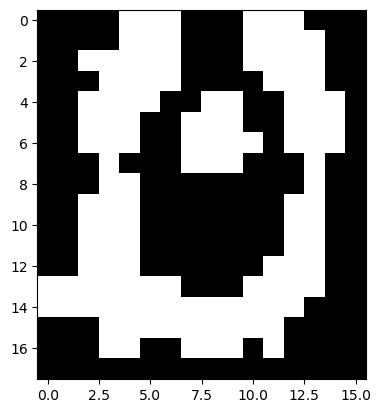

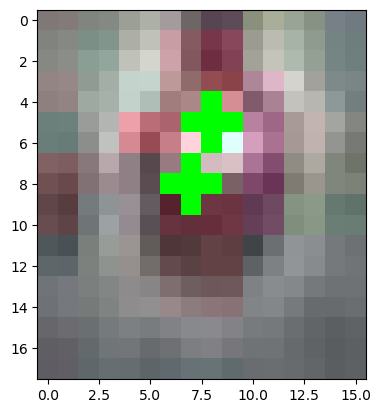

(18, 16, 3)


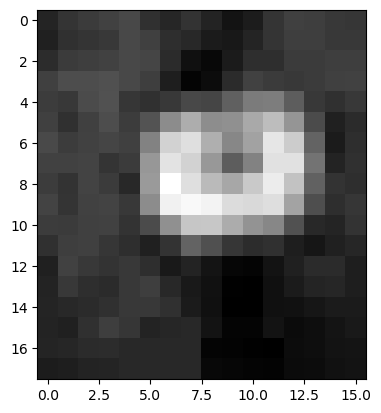

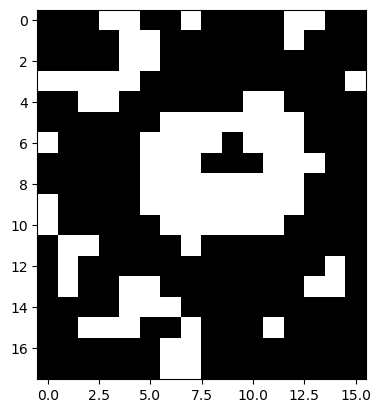

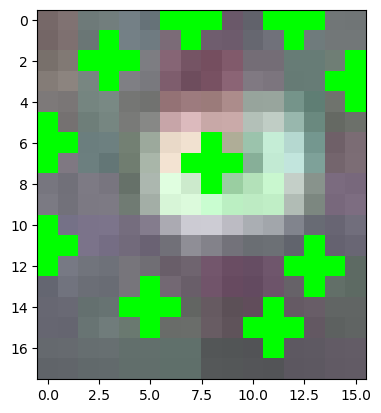

(18, 16, 3)


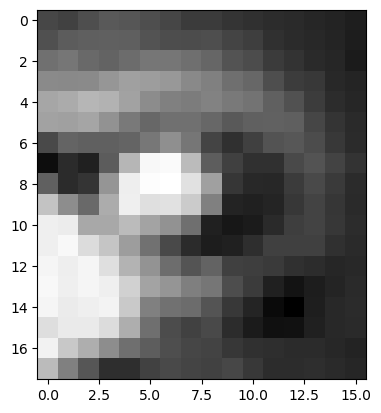

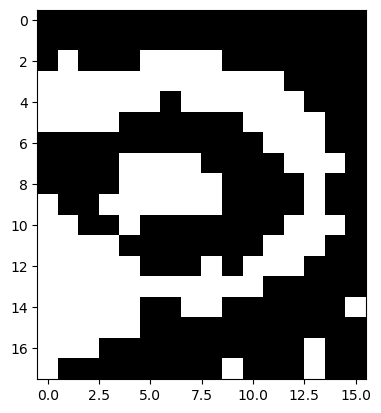

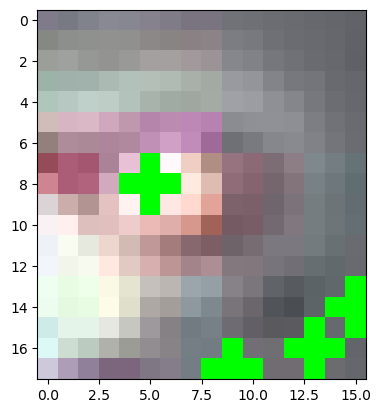

(18, 16, 3)


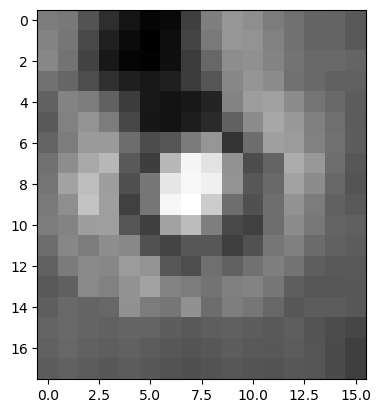

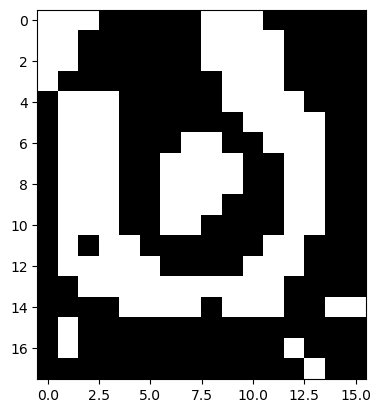

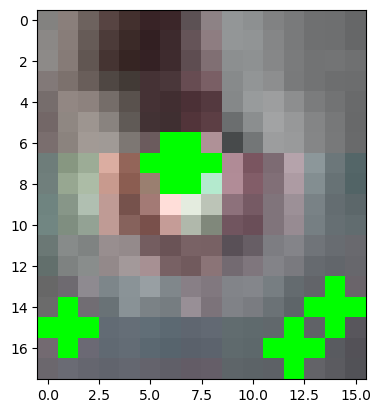

(18, 16, 3)


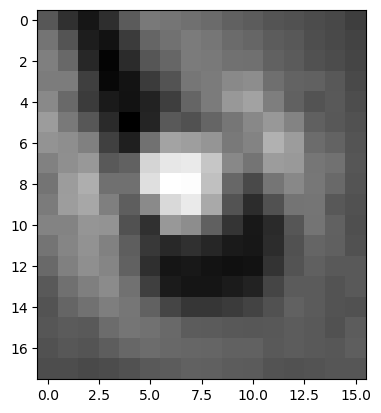

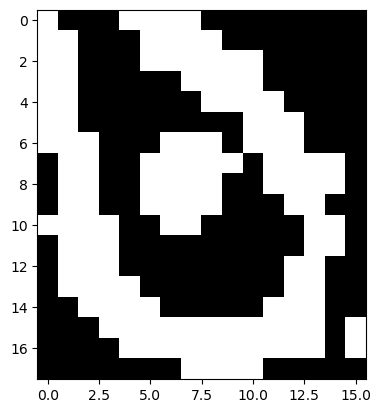

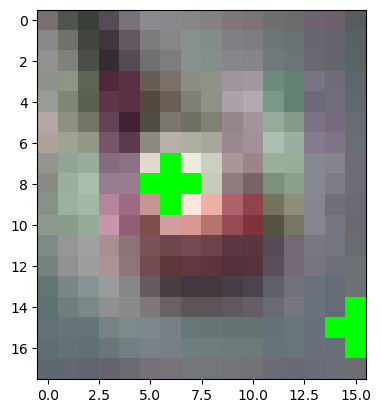

(18, 16, 3)


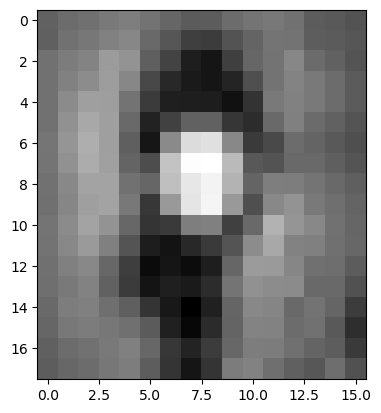

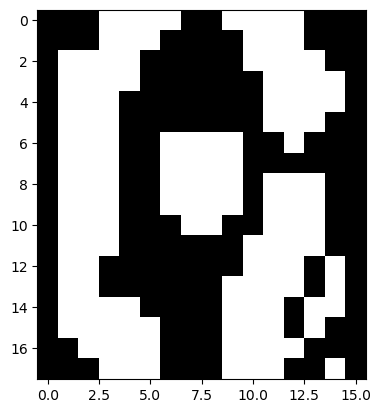

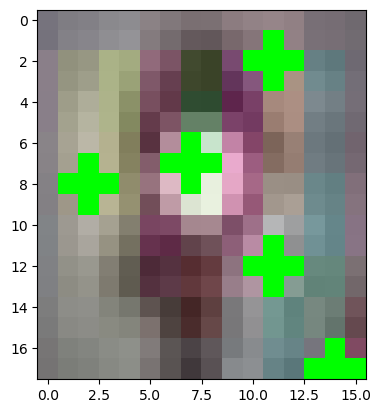

(18, 16, 3)


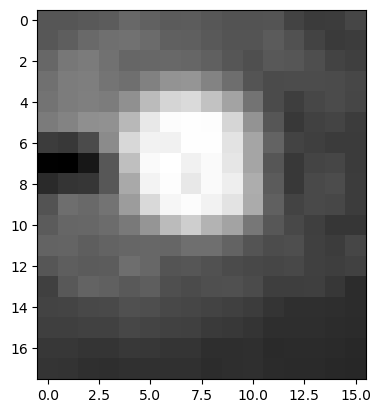

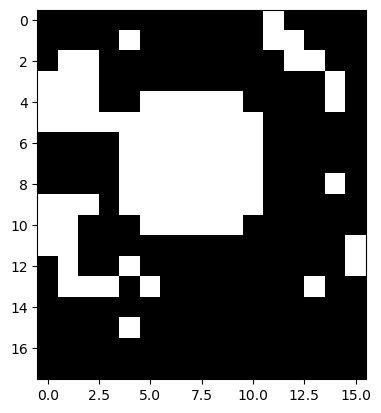

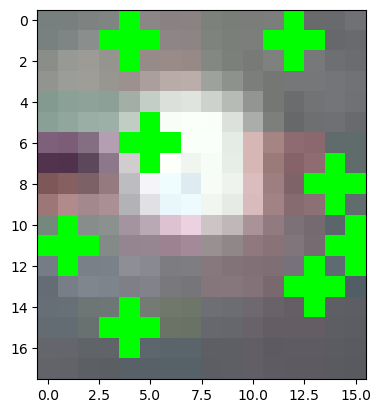

(18, 16, 3)


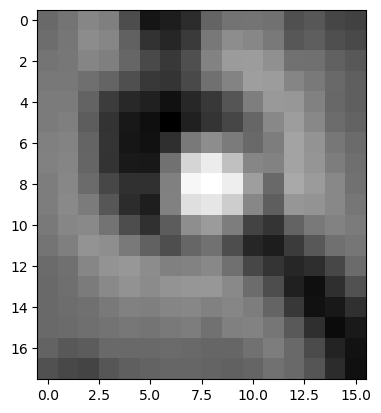

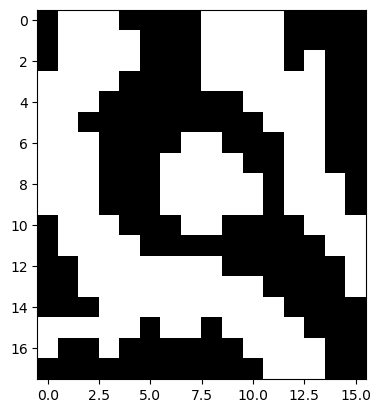

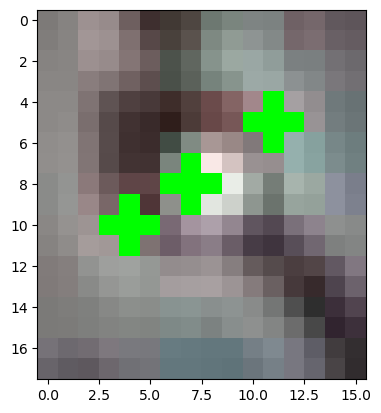

(18, 16, 3)


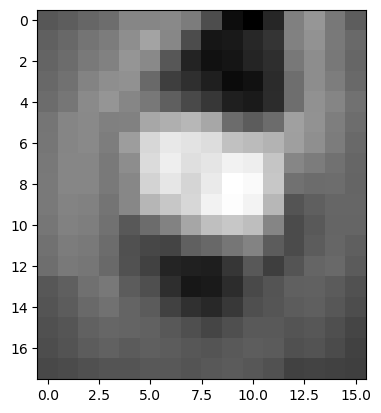

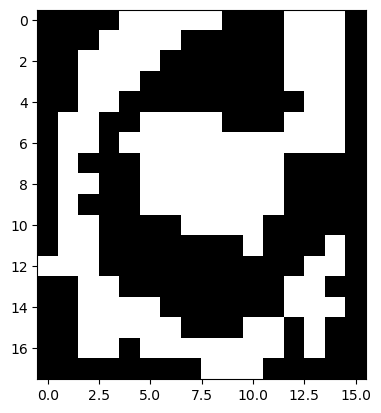

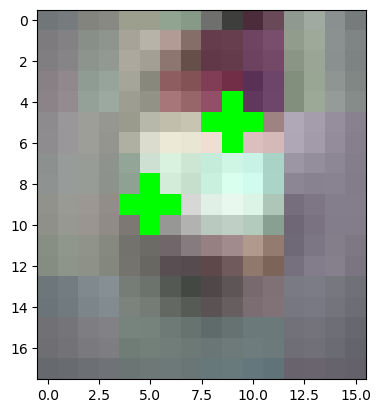

(14, 14, 3)


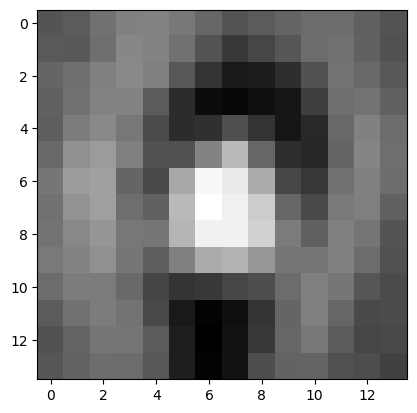

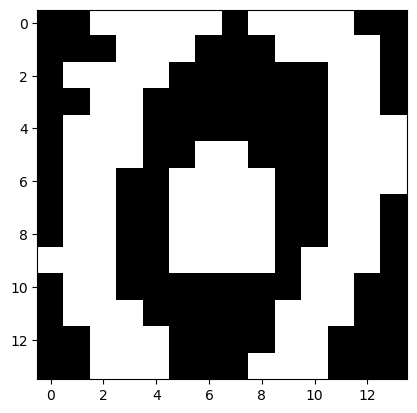

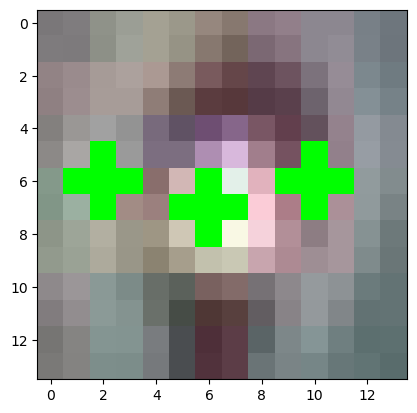

(14, 16, 3)


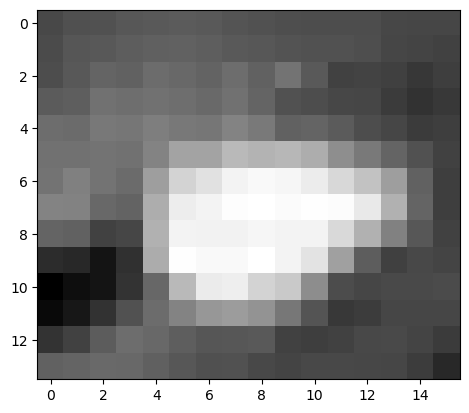

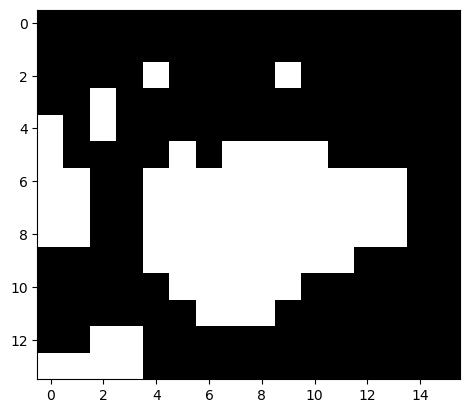

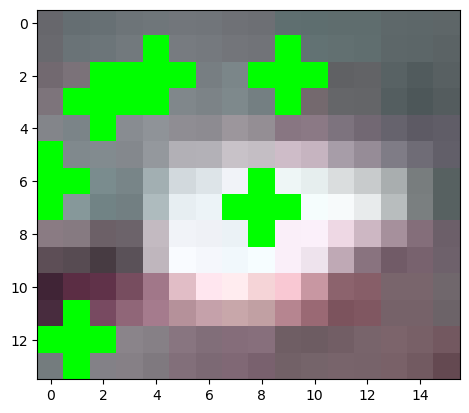

(14, 16, 3)


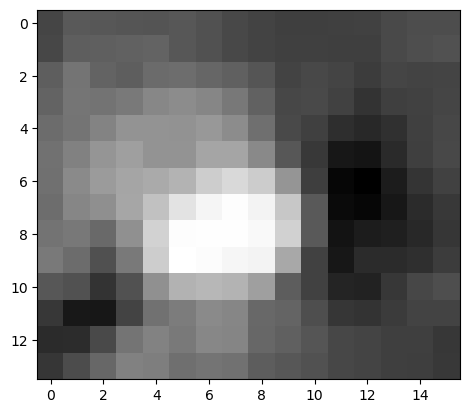

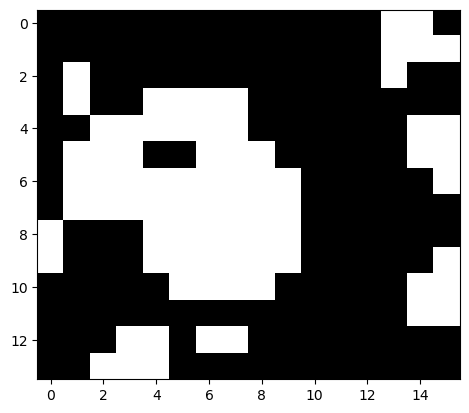

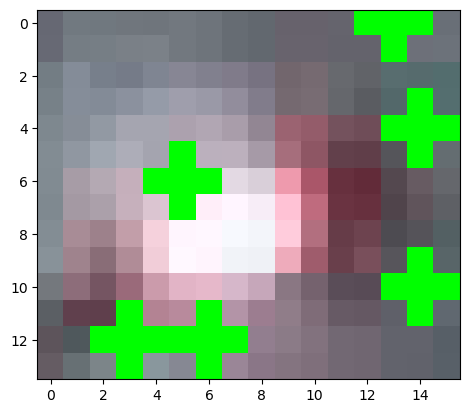

In [ ]:
import trackpy as tp
import pandas as pd
import cv2

# Determine true centers using trackpy

def detectTrueCenter(cropped_im):
    predictions = tp.locate(cropped_im, diameter=5, minmass=50, separation=5)

    if predictions.empty:
        print("No predictions found.")
        return None

    # Take the row with the highest mass
    predictions = predictions.loc[predictions['mass'] == predictions['mass'].max()]

    return predictions

def detectTrueCenter2(cropped_im):
    f = pd.DataFrame(columns=['y', 'x', 'frame'])

    plt.imshow(cropped_im,cmap='gray')
    plt.show()

    # Find centroids by focusing on heads
    bw = tracker.threshold(cropped_im, method='adaptive')
    plt.imshow(bw,cmap='gray')
    plt.show()
    _, _, _, centroids = cv2.connectedComponentsWithStats(bw, 4, cv2.CV_32S) 

    # Filter out the background (always index 0)
    centroids = centroids[1:]

    # Add centroids to dataframe
    for centroid in centroids:
        f.loc[len(f.index)] = [centroid[1], centroid[0], i]

    return f

# Draw the opencv detection
for i in range(25):
    x = int(sperm.iloc[i]["x"])
    y = int(sperm.iloc[i]["y"])
    w = int(sperm.iloc[i]["bbox_w"])
    h = int(sperm.iloc[i]["bbox_h"])
    im = original[y-h:y+h, x-w:x+w]
    im_g = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    print(im.shape)
    info = detectTrueCenter(im_g)
    for j in range(len(info)):
        x = int(info.iloc[j]["x"])
        y = int(info.iloc[j]["y"])
        cv2.circle(im, (x, y), 1, (0, 255, 0), -1)
    plt.imshow(im)
    plt.show()



## Correction Pipeline

In [8]:
# Visualize example
example_vid = data_folder + videofiles[0]
example_csv = data_folder + csvfiles[0]

frames = utils.loadVideo(example_vid)
df = utils.loadDataFrame(example_csv)

In [9]:
def detectCroppedCenter(cropped_im):
    cx = int(cropped_im.shape[1] / 2)
    cy = int(cropped_im.shape[0] / 2)

    predictions = tp.locate(cropped_im, diameter=5, minmass=100, separation=5)

    if predictions.empty:
        return 0, 0

    # Take the row with the highest mass
    predictions = predictions.loc[predictions['mass'] == predictions['mass'].max()]

    # Get the x and y coordinates
    x = int(predictions.iloc[0]["x"])
    y = int(predictions.iloc[0]["y"])

    return x-cx,y-cy

# Make a copy of the dataframe
result_df = df.copy()

# Go through each row of the dataframe
for i in range(len(df)):
    # Get the frame number
    frame_num = int(df.iloc[i]["frame"])

    # Get the x and y coordinates
    x = int(df.iloc[i]["x"])
    y = int(df.iloc[i]["y"])
    w = int(df.iloc[i]["bbox_w"])
    h = int(df.iloc[i]["bbox_h"])
    frame = frames[frame_num]

    # Detect the true center
    cropped_im = frame[y-h:y+h, x-w:x+w]
    im_g = cv2.cvtColor(cropped_im, cv2.COLOR_BGR2GRAY)
    crop_x, crop_y = detectCroppedCenter(im_g)

    # Replace the x and y coordinates with the detected center in df
    cur_x = x + crop_x
    cur_y = y + crop_y
    result_df.at[i, "x"] = cur_x
    result_df.at[i, "y"] = cur_y

/opt/miniconda3/envs/pytorch/lib/python3.11/site-packages/trackpy/feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "
/opt/miniconda3/envs/pytorch/lib/python3.11/site-packages/trackpy/feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the mass computation was changed from version 0.2.4 to 0.3.0 and from 0.3.3 to 0.4.0. See the documentation and the convenience functions 'minmass_v03_change' and 'minmass_v04_change'.
  warnings.warn("No maxima survived mass- and size-based filtering. "
/opt/miniconda3/envs/pytorch/lib/python3.11/site-packages/trackpy/feature.py:425: UserWarning: No maxima survived mass- and size-based filtering. Be advised that the 

In [10]:
#Visualize the result

visualizer.runVisualization(example_vid, result_df, visualization="flow")

(57, 3)
Video Finished.


### Feed through the statistics pipeline

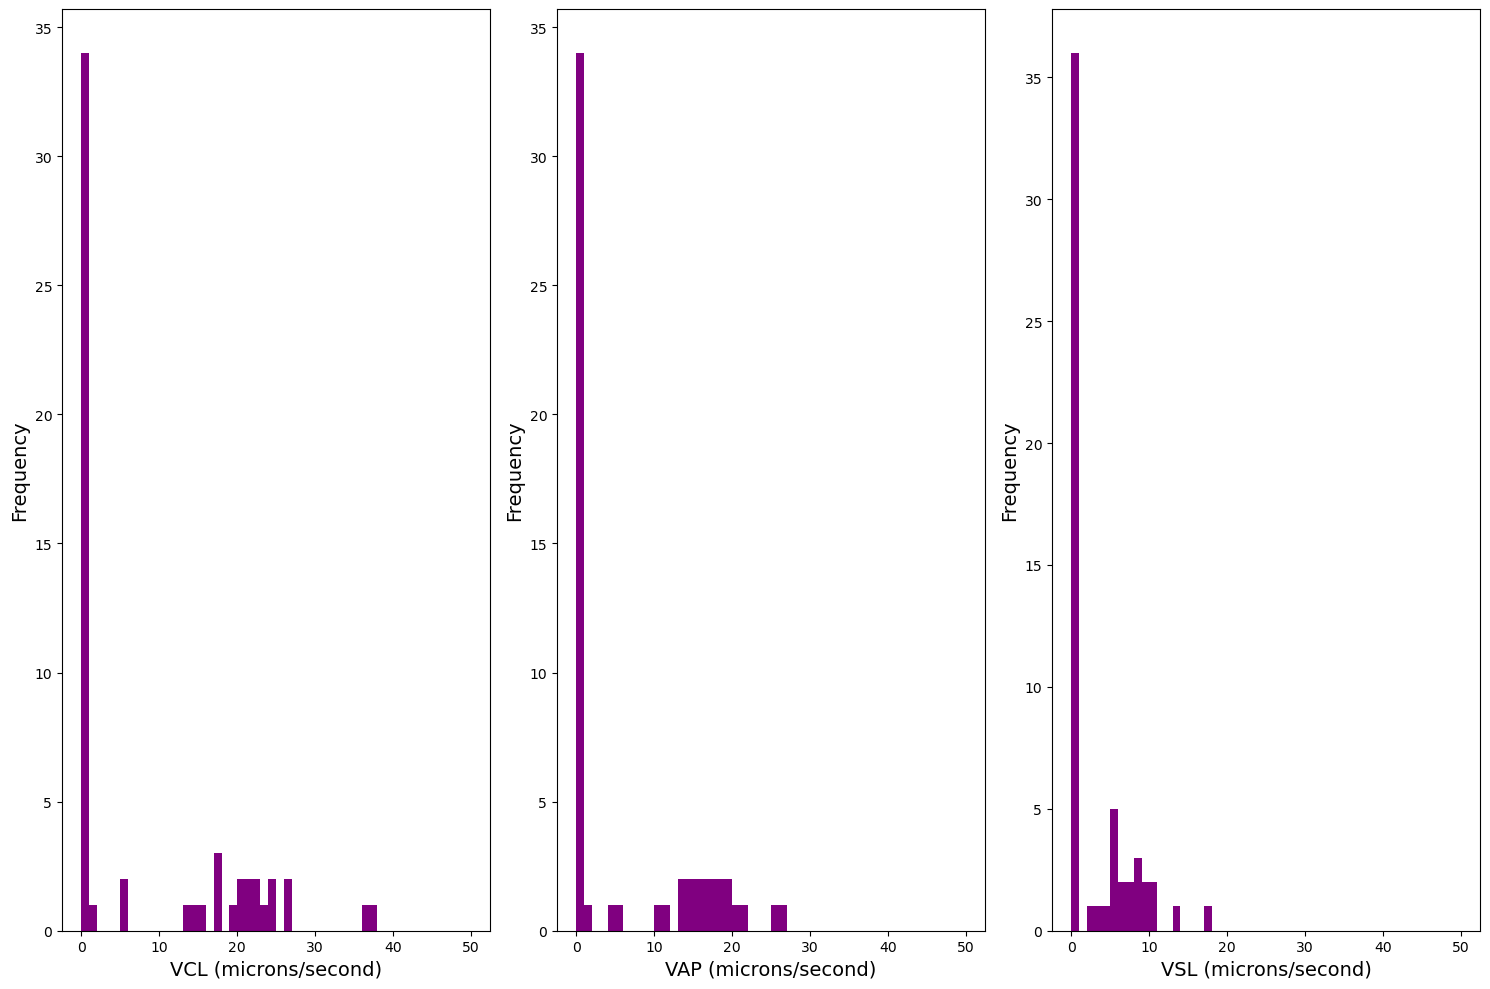

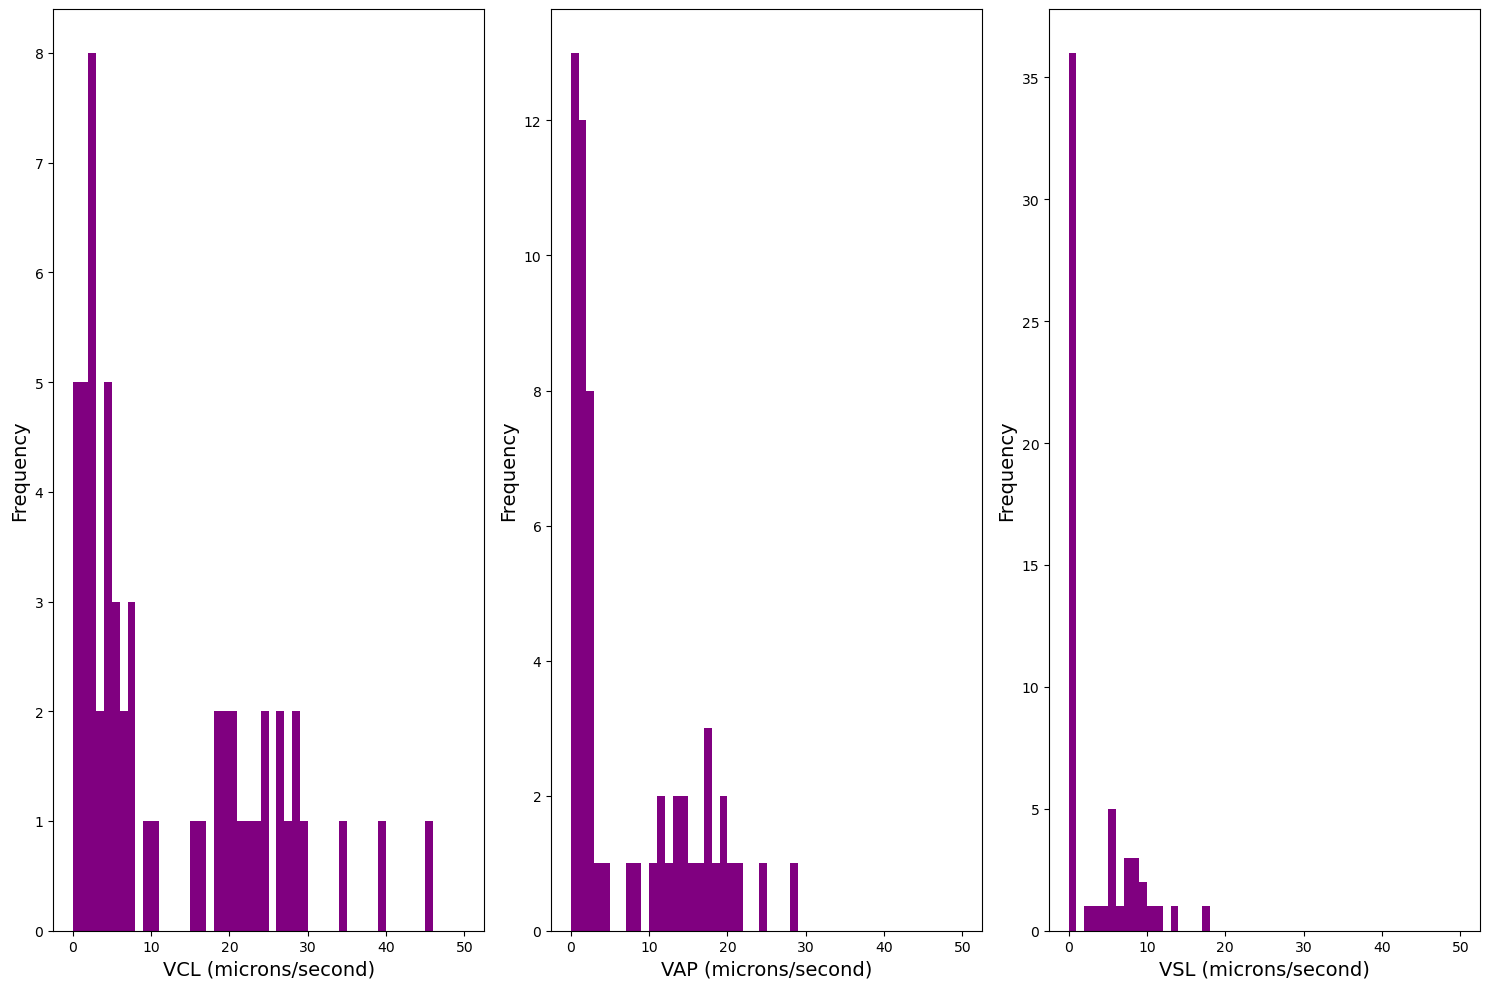

   sperm  type      x      y  bbox_w  bbox_h  frame       VAP       VCL  \
0    0.0   0.0  176.0  198.0     8.0     9.0    0.0  0.111997  0.111769   
1    0.0   0.0  176.0  198.0     8.0     9.0    1.0  0.111997  0.111769   
2    0.0   0.0  176.0  198.0     8.0     9.0    2.0  0.111997  0.111769   
3    0.0   0.0  176.0  198.0     8.0     9.0    3.0  0.111997  0.111769   
4    0.0   0.0  176.0  198.0     8.0     9.0    4.0  0.111997  0.111769   

        VSL  ALH_mean  ALH_max  BCF  
0  0.083684       NaN      NaN  0.0  
1  0.083684       NaN      NaN  0.0  
2  0.083684       NaN      NaN  0.0  
3  0.083684       NaN      NaN  0.0  
4  0.083684       NaN      NaN  0.0  


In [70]:
importlib.reload(stats)

final = stats.computeAllStats(df)
stats.plotAllStats(final)

final2 = stats.computeAllStats(result_df)
stats.plotAllStats(final2)

In [ ]:
#utils.saveDataFrame(results_df, videofile.split('.')[0] + '_corrected.csv')